# Imports

In [1]:
import logging
import warnings
import os
import pickle
import time
import json

import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             roc_auc_score)

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from xgboost import XGBModel
from sklearn.base import BaseEstimator

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks

from lightgbm import LGBMClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

# Some data exploration

In [4]:
df = pd.read_csv("../data/train.csv")
df.head()

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [5]:
df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating                243787 non-null  f

In [7]:
df.isnull().sum()

AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
Churn                       0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

# Data profiling

In [ ]:
# Generate the report
profile = ProfileReport(df,title="Customer Churn EDA Report")

# Save the report to .html
profile.to_file("customer_churn_eda_report.html")

After reviewing the data profiling result (open `customer_churn_eda_report.html` in your browser), we see:
- there are no missing data.
- we need to apply normalization and some data preprocessing
- There are correlations with the Churn variable, but not strong enough.
- We have 21 variables (including target and CustomerID)
    - 9 numeric
    - 7 categorical
    - 4 boolean (automatically detected, because they were Yes or No)
    - 1 text (CustomerID)
- The only umbalanced class is Churn

We will check if we find outliers in the boxplots

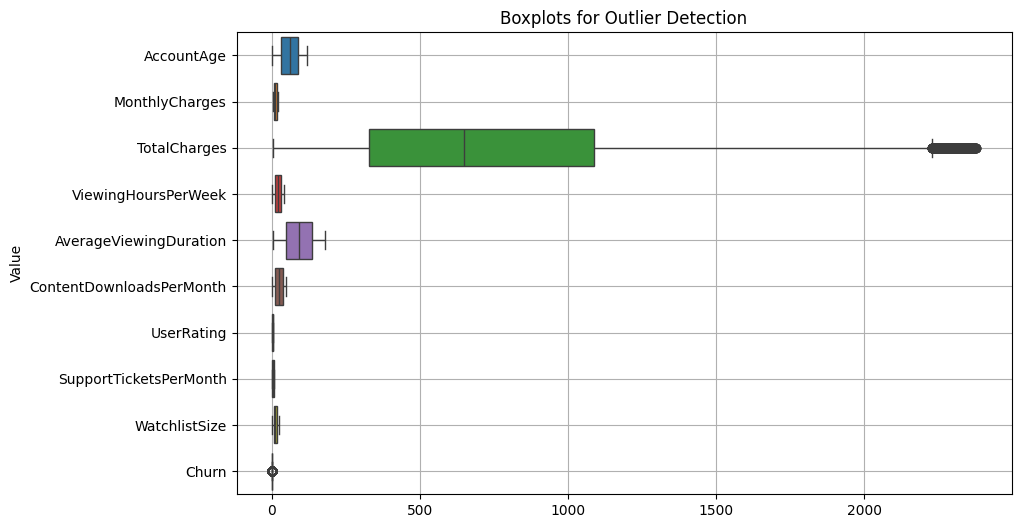

In [10]:
# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient="h")
plt.title("Boxplots for Outlier Detection")
plt.ylabel("Value")
plt.grid(True)
plt.show()

Seems to be some outliers in Total charges. We will remove the outliers in the preprocessing step

# Preprocessing


Pending to try removing outliers

In [11]:
# Transform the Yes/No columns into booleans
yes_no_columns = ['PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered']
for col in yes_no_columns:
    if df[col].nunique() == 2:
        df[col] = df[col].map({'Yes': True, 'No': False})

In [12]:
# Remove the CustomerID column
df = df.drop(columns=['CustomerID'])

In [13]:
df.head()

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,Churn
0,20,11.055215,221.104302,Premium,Mailed check,False,Both,False,Mobile,36.758104,63.531377,10,Sci-Fi,2.176498,4,Male,3,No,No,0
1,57,5.175208,294.986882,Basic,Credit card,True,Movies,False,Tablet,32.450568,25.725595,18,Action,3.478632,8,Male,23,No,Yes,0
2,73,12.106657,883.785952,Basic,Mailed check,True,Movies,False,Computer,7.395160,57.364061,23,Fantasy,4.238824,6,Male,1,Yes,Yes,0
3,32,7.263743,232.439774,Basic,Electronic check,False,TV Shows,False,Tablet,27.960389,131.537507,30,Drama,4.276013,2,Male,24,Yes,Yes,0
4,57,16.953078,966.325422,Premium,Electronic check,True,TV Shows,False,TV,20.083397,45.356653,20,Comedy,3.616170,4,Female,0,No,No,0


In [14]:
target = 'Churn'

# Detect numeric, categorical and binary features
numeric_features = df.drop(columns=[target]).select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.drop(columns=[target]).select_dtypes(include=['object']).columns.tolist()
binary_features = df.drop(columns=[target]).select_dtypes(include=['bool']).columns.tolist()

print(f"Total Numeric features in the dataset {len(numeric_features)} : {numeric_features}")
print(f"Total Categorical features in the dataset {len(categorical_features)} : {categorical_features}")
print(f"Total Binary features in the dataset {len(binary_features)} : {binary_features}")
print(f"Target: {target}")

Total Numeric features in the dataset 9 : ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize']
Total Categorical features in the dataset 8 : ['SubscriptionType', 'PaymentMethod', 'ContentType', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled']
Total Binary features in the dataset 2 : ['PaperlessBilling', 'MultiDeviceAccess']
Target: Churn


In [15]:
y = df[target].copy()
X = df.drop(target, axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to ensure the split is balanced (as the datase is unbalanced)

In [16]:
X_train.head()

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled
112198,54,18.667225,1008.030146,Premium,Credit card,False,TV Shows,True,Tablet,17.892616,171.307716,8,Action,1.585760,4,Female,17,Yes,Yes
35340,37,13.340015,493.580571,Premium,Electronic check,True,TV Shows,True,TV,36.133729,174.965535,35,Action,3.799440,1,Male,15,No,Yes
33223,77,11.440717,880.935206,Premium,Credit card,True,TV Shows,True,Tablet,39.479837,66.082295,23,Fantasy,1.881155,3,Male,13,Yes,Yes
188717,13,16.872436,219.341666,Basic,Mailed check,True,TV Shows,True,Tablet,29.012386,56.929637,13,Comedy,4.642076,4,Male,13,No,No
81575,55,17.075056,939.128054,Premium,Credit card,True,Both,True,Mobile,26.256367,73.157747,25,Comedy,2.121783,9,Male,15,No,Yes


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler()) # Normalize the data using MinMaxScaler since the columns are not normally distributed, so we need to preserve the distribution
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),
        ('bin', 'passthrough', binary_features)
    ],
    remainder='drop'
)

In [18]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [19]:
print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)

(195029, 36)
(48758, 36)


In [20]:
feature_names = preprocessor.get_feature_names_out()
feature_names.shape

(36,)

In [21]:
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

In [22]:
X_train_preprocessed_df.head()

,num__AccountAge,num__MonthlyCharges,num__TotalCharges,num__ViewingHoursPerWeek,num__AverageViewingDuration,num__ContentDownloadsPerMonth,num__UserRating,num__SupportTicketsPerMonth,num__WatchlistSize,cat__SubscriptionType_Basic,...,cat__GenrePreference_Fantasy,cat__GenrePreference_Sci-Fi,cat__Gender_Female,cat__Gender_Male,cat__ParentalControl_No,cat__ParentalControl_Yes,cat__SubtitlesEnabled_No,cat__SubtitlesEnabled_Yes,bin__PaperlessBilling,bin__MultiDeviceAccess
0,0.449153,0.911817,0.422558,0.433146,0.950333,0.163265,0.146439,0.444444,0.708333,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.305085,0.556666,0.205832,0.900871,0.971236,0.714286,0.699864,0.111111,0.625000,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2,0.644068,0.430045,0.369015,0.986669,0.349040,0.469388,0.220289,0.333333,0.541667,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,0.101695,0.792163,0.090301,0.718271,0.296738,0.265306,0.910525,0.444444,0.541667,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,0.457627,0.805671,0.393531,0.647603,0.389471,0.510204,0.280446,1.000000,0.625000,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [23]:
def save_pickle(model, filename, path="models", extension=".pkl") -> None:
    # Create the directory if it doesn't exist
    os.makedirs(path, exist_ok=True)

    filepath = os.path.join(path, f"{filename}{extension}")
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)

    return filepath

def save_json(data, filename, path="models", extension=".json"):
    # Create the directory if it doesn't exist
    os.makedirs(path, exist_ok=True)

    filepath = os.path.join(path, f"{filename}{extension}")
    with open(filepath, 'w') as file:
        json.dump(data, file)

    return filepath

scaler_path = save_pickle(preprocessor, "preprocessor", "../models")
################### features_path = save_json(relevant_features, "features", "../models", ".json")

# Model training
As I don't see any clear correlations, I will go to feature selection and test multiple models.

For trcking I will use MLflow, so we can keep record of our experiments and choose the best model with the best params later.

Run the following command to launch the mlflow ui locally. Do it at the project root level

`mlflow ui --backend-store-uri sqlite:///backend.db`

This is for local usage. We can setup a MLFlow server to track our experiments and a bucket to store outartifacts the cloud.

In [24]:
# tracking_uri = "sqlite:///../backend.db"
tracking_uri = "http://127.0.0.1:5050"
experiment_name = "customer-churn-experiment"

In [25]:
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.autolog()
#mlflow.sklearn.autolog()
#mlflow.xgboost.autolog()

2025/08/02 15:58:53 INFO mlflow.tracking.fluent: Experiment with name 'customer-churn-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1754168333876, experiment_id='1', last_update_time=1754168333876, lifecycle_stage='active', name='customer-churn-experiment', tags={}>

In [26]:
def display_and_log_metrics(model, preprocessor_path, name_model, developer, X_train, y_train, X_test, y_test, training_time, features_path, use_cv=False):
    with mlflow.start_run():
        mlflow.set_tag("model", name_model)
        mlflow.set_tag("developer", developer)

        mlflow.log_metric("training_time", training_time)

        y_train_pred_proba = model.predict_proba(X_train)[:, 1] # As the model is a binary classifier, we only need the probability of the positive class
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]
        
        roc_auc_score_train = round(
            roc_auc_score(y_train, y_train_pred_proba, average="weighted"), 2
        )
        roc_auc_score_test = round(
            roc_auc_score(y_test, y_test_pred_proba, average="weighted"), 2
        )

        logger.info("ROC AUC Score Train: %s", roc_auc_score_train)
        logger.info("ROC AUC Score Test: %s", roc_auc_score_test)
        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_pred_train, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_pred_test, average="weighted")

        (
            positive_precision_test,
            positive_recall_test,
            positive_fscore_test,
            positive_support_test,
        ) = precision_recall_fscore_support(y_test, y_pred_test, average="binary", pos_label=1)
        (
            negative_precision_test,
            negative_recall_test,
            negative_fscore_test,
            negative_support_test,
        ) = precision_recall_fscore_support(y_test, y_pred_test, average="binary", pos_label=0)

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("fscore_train", fscore_train)
        mlflow.log_metric("fscore_test", fscore_test)

        mlflow.log_metric("positive_precision_test", positive_precision_test)
        mlflow.log_metric("positive_recall_test", positive_recall_test)
        mlflow.log_metric("positive_fscore_test", positive_fscore_test)
        
        mlflow.log_metric("negative_precision_test", negative_precision_test)
        mlflow.log_metric("negative_recall_test", negative_recall_test)
        mlflow.log_metric("negative_fscore_test", negative_fscore_test)

        if support_train:
            mlflow.log_metric("support_train", support_train)
        if support_test:
            mlflow.log_metric("support_test", support_test)
        if positive_support_test:
            mlflow.log_metric("positive_support_test", positive_support_test)
        if negative_support_test:
            mlflow.log_metric("negative_support_test", negative_support_test)

        logger.info("Precision Train: %s", precision_train)
        logger.info("Precision Test: %s", precision_test)
        logger.info("Recall Train: %s", recall_train)
        logger.info("Recall Test: %s", recall_test)
        logger.info("Fscore Train: %s", fscore_train)
        logger.info("Fscore Test: %s", fscore_test)
        logger.info("Support Train: %s", support_train)
        logger.info("Support Test: %s", support_test)

        logger.info("Positive Precision Test: %s", positive_precision_test)
        logger.info("Positive Recall Test: %s", positive_recall_test)
        logger.info("Positive Fscore Test: %s", positive_fscore_test)
        logger.info("Positive Support Test: %s", positive_support_test)

        logger.info("Negative Precision Test: %s", negative_precision_test)
        logger.info("Negative Recall Test: %s", negative_recall_test)
        logger.info("Negative Fscore Test: %s", negative_fscore_test)
        logger.info("Negative Support Test: %s", negative_support_test)

        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()

            mlflow.log_params(best_params)

        except AttributeError as e:
            print(e)

        if isinstance(model, XGBModel):
            mlflow.xgboost.log_model(model, name=f"model", input_example=X_train.iloc[0].values.reshape(1, -1))
        elif isinstance(model, BaseEstimator):
            mlflow.sklearn.log_model(model, name=f"model", input_example=X_train.iloc[0].values.reshape(1, -1))
        else:
            raise ValueError("Unsupported model type for MLflow logging.")

        mlflow.log_artifact(preprocessor_path, artifact_path="preprocessor")

        # Log selected features
        mlflow.log_artifact(features_path, artifact_path="features")


        model_report_train = classification_report(y_train, y_pred_train)
        model_report_test = classification_report(y_test, y_pred_test)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(12, 8))

        cm = confusion_matrix(y_test, y_pred_test)
        cmp = ConfusionMatrixDisplay(cm, display_labels=["Not Churn", "Churn"]) # TODO: Review labels
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

In [27]:
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

In [28]:
def optimize_and_log_model(model, search_space, model_name, X_train, y_train,
                           X_test, y_test, developer, scaler_path, features_path,
                           n_iter=25, cv=5, scoring=["f1_weighted", "roc_auc", "recall"]):
    search = BayesSearchCV(
        estimator=clone(model),
        search_spaces=search_space,
        scoring=scoring,
        n_iter=n_iter,
        cv=cv,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)

    print_best_score_params(search)

    best_model = search.best_estimator_


    start_time = time.time()
    best_model.fit(X_train, y_train)
    end_time = time.time()

    trainging_time = end_time - start_time

    display_and_log_metrics(
        best_model,
        scaler_path,
        model_name,
        developer,
        X_train, y_train,
        X_test, y_test,
        trainging_time, features_path
    )

    return best_model, search

### Feature selection
We will start by selecting some characteristics for the models.

For me, the most important metric is recall, because if we predict that a customer won't leave, but they actually do, it will be worse than predicting that someone will leave but doesn't.

That's why I'll focus my analysis on recall.

In [29]:
scoring = ["f1_weighted", "roc_auc", "recall"]

In [30]:
def compare_feature_selectors_multiple_models(X_train, y_train, 
                                              feature_names=None,
                                              base_models=None,
                                              cv=5,
                                              scoring=["f1_weighted"],
                                              verbose=True):
    """
    Compares feature selectors (LassoCV, ElasticNetCV, RandomForest, XGBoost)
    and evaluates multiple base models on the selected features.
    
    Returns:
        - results_df: DataFrame summarizing RMSE results.
        - selected_features_dict: Dictionary with selected feature names per selector.
    """

    # Define default models to test if none are given
    if base_models is None:
        base_models = {
            "LogisticRegression": LogisticRegression(max_iter=100, random_state=42),
            "RandomForest": RandomForestClassifier(n_estimators=25, random_state=42),
            "XGBoost": XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42),
            "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
        }

    # Define feature selectors (including XGBoost)
    selectors = {
        "L1 Logistic": SelectFromModel(LogisticRegression(penalty="l1", solver="liblinear", random_state=42)),
        "ElasticNet": SelectFromModel(LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, random_state=42, max_iter=100)),
        "RandomForest": SelectFromModel(RandomForestClassifier(n_estimators=25, random_state=42)),
        "XGBoost": SelectFromModel(XGBClassifier(n_estimators=100, uval_metric='logloss', random_state=42)),
    }

    results = []
    selected_features_dict = {}

    for selector_name, selector in selectors.items():
        print(f"\nRunning {selector_name}...")
        selector.fit(X_train, y_train)
        X_train_sel = selector.transform(X_train)

        # Save selected feature names
        if feature_names is not None:
            indices = selector.get_support(indices=True)
            selected_features_dict[selector_name] = [feature_names[i] for i in indices]

        for model_name, model in base_models.items():
            print(f"\nTraining {model_name}...")

            row = {
                "Selector": selector_name,
                "Model": model_name,
                "N Selected Features": X_train_sel.shape[1]
            }

            for metric in scoring:
                cv_score = cross_val_score(model, X_train_sel, y_train, cv=cv, scoring=metric, n_jobs=-1)
                row[metric] = np.mean(cv_score)

                if verbose:
                    print(f"[{selector_name} + {model_name}] - {metric}: {row[metric]:.4f}")


            results.append(row)

    results_df = pd.DataFrame(results).sort_values(by=scoring[0], ascending=False)
    return results_df, selected_features_dict


In [31]:
results_df, selected_features = compare_feature_selectors_multiple_models(
    X_train_preprocessed_df, y_train,
    feature_names=feature_names,
    cv=3,
    scoring=scoring
)


Running L1 Logistic...

Training LogisticRegression...
[L1 Logistic + LogisticRegression] - f1_weighted: 0.7730
[L1 Logistic + LogisticRegression] - roc_auc: 0.7490
[L1 Logistic + LogisticRegression] - recall: 0.1168

Training RandomForest...
[L1 Logistic + RandomForest] - f1_weighted: 0.7638
[L1 Logistic + RandomForest] - roc_auc: 0.6993
[L1 Logistic + RandomForest] - recall: 0.0917

Training XGBoost...
[L1 Logistic + XGBoost] - f1_weighted: 0.7732
[L1 Logistic + XGBoost] - roc_auc: 0.7320
[L1 Logistic + XGBoost] - recall: 0.1312

Training LightGBM...


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LightGBM] - f1_weighted: 0.7712


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LightGBM] - roc_auc: 0.7442


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LightGBM] - recall: 0.1118

Running ElasticNet...

Training LogisticRegression...
[ElasticNet + LogisticRegression] - f1_weighted: 0.7703
[ElasticNet + LogisticRegression] - roc_auc: 0.7445
[ElasticNet + LogisticRegression] - recall: 0.1065

Training RandomForest...
[ElasticNet + RandomForest] - f1_weighted: 0.7717
[ElasticNet + RandomForest] - roc_auc: 0.6967
[ElasticNet + RandomForest] - recall: 0.1406

Training XGBoost...
[ElasticNet + XGBoost] - f1_weighted: 0.7698
[ElasticNet + XGBoost] - roc_auc: 0.7296
[ElasticNet + XGBoost] - recall: 0.1146

Training LightGBM...


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LightGBM] - f1_weighted: 0.7684


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LightGBM] - roc_auc: 0.7397


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LightGBM] - recall: 0.1011

Running RandomForest...

Training LogisticRegression...
[RandomForest + LogisticRegression] - f1_weighted: 0.7707
[RandomForest + LogisticRegression] - roc_auc: 0.7455
[RandomForest + LogisticRegression] - recall: 0.1082

Training RandomForest...
[RandomForest + RandomForest] - f1_weighted: 0.7710
[RandomForest + RandomForest] - roc_auc: 0.6982
[RandomForest + RandomForest] - recall: 0.1358

Training XGBoost...
[RandomForest + XGBoost] - f1_weighted: 0.7715
[RandomForest + XGBoost] - roc_auc: 0.7292
[RandomForest + XGBoost] - recall: 0.1219

Training LightGBM...


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LightGBM] - f1_weighted: 0.7694


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LightGBM] - roc_auc: 0.7407


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LightGBM] - recall: 0.1049

Running XGBoost...

Training LogisticRegression...
[XGBoost + LogisticRegression] - f1_weighted: 0.7719
[XGBoost + LogisticRegression] - roc_auc: 0.7472
[XGBoost + LogisticRegression] - recall: 0.1123

Training RandomForest...
[XGBoost + RandomForest] - f1_weighted: 0.7712
[XGBoost + RandomForest] - roc_auc: 0.7002
[XGBoost + RandomForest] - recall: 0.1362

Training XGBoost...
[XGBoost + XGBoost] - f1_weighted: 0.7717
[XGBoost + XGBoost] - roc_auc: 0.7315
[XGBoost + XGBoost] - recall: 0.1236

Training LightGBM...


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LightGBM] - f1_weighted: 0.7696


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LightGBM] - roc_auc: 0.7429


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LightGBM] - recall: 0.1059


In [32]:
results_df.sort_values("recall", ascending=False)

,Selector,Model,N Selected Features,f1_weighted,roc_auc,recall
5,ElasticNet,RandomForest,6,0.771677,0.696668,0.140557
13,XGBoost,RandomForest,10,0.771224,0.700211,0.136200
9,RandomForest,RandomForest,9,0.771012,0.698172,0.135776
2,L1 Logistic,XGBoost,34,0.773193,0.731993,0.131249
14,XGBoost,XGBoost,10,0.771741,0.731528,0.123610
10,RandomForest,XGBoost,9,0.771472,0.729158,0.121941
0,L1 Logistic,LogisticRegression,34,0.773027,0.748991,0.116820
6,ElasticNet,XGBoost,6,0.769773,0.729593,0.114641
12,XGBoost,LogisticRegression,10,0.771853,0.747228,0.112321
3,L1 Logistic,LightGBM,34,0.771188,0.744153,0.111812


In [33]:
# Sort again
results_df = pd.DataFrame(results_df).sort_values("recall", ascending=False)

# Get the best selector and used features
best_selector = results_df.iloc[0]["Selector"]
best_features = selected_features[best_selector]

print(f"Best selector: {best_selector}")
print(f"Best features: {best_features}")

Best selector: ElasticNet
Best features: ['num__AccountAge', 'num__MonthlyCharges', 'num__ViewingHoursPerWeek', 'num__AverageViewingDuration', 'num__ContentDownloadsPerMonth', 'num__SupportTicketsPerMonth']


## Let's try SMOTE

In [34]:
# We need to apply SMOTE inside the pipeline to avoid data leakage when running cross-validation in the compare_feature_selectors_multiple_models function
models = {
    "LogisticRegression": ImbPipeline(
        [
            ('smote', SMOTE(random_state=42)),   # <--- Inside the fold
            ('clf', LogisticRegression())
            ]
        ),
    "RandomForestClassifier": ImbPipeline(
        [
            ('smote', SMOTE(random_state=42)),
            ('clf', RandomForestClassifier())
            ]
        ),
    "XGBClassifier": ImbPipeline(
        [
            ('smote', SMOTE(random_state=42)),
            ('clf', XGBClassifier())
            ]
        ),
    "LGBMClassifier": ImbPipeline(
        [
            ('smote', SMOTE(random_state=42)),
            ('clf', LGBMClassifier())
            ]
        )
}

results_df_smote, selected_features_smote = compare_feature_selectors_multiple_models(
    X_train_preprocessed_df, y_train,
    feature_names=feature_names,
    cv=3,
    base_models=models,
    scoring=scoring
)


Running L1 Logistic...

Training LogisticRegression...
[L1 Logistic + LogisticRegression] - f1_weighted: 0.7181
[L1 Logistic + LogisticRegression] - roc_auc: 0.7488
[L1 Logistic + LogisticRegression] - recall: 0.6811

Training RandomForestClassifier...
[L1 Logistic + RandomForestClassifier] - f1_weighted: 0.7717
[L1 Logistic + RandomForestClassifier] - roc_auc: 0.7143
[L1 Logistic + RandomForestClassifier] - recall: 0.3319

Training XGBClassifier...
[L1 Logistic + XGBClassifier] - f1_weighted: 0.7768
[L1 Logistic + XGBClassifier] - roc_auc: 0.7330
[L1 Logistic + XGBClassifier] - recall: 0.1490

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8664
[LightGBM] [Info] Number of data poin

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LGBMClassifier] - f1_weighted: 0.7775
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8664
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8664
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 34
[LightGBM] [In

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LGBMClassifier] - roc_auc: 0.7427
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8664
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8664
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 34
[LightGBM] [Info] 

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LGBMClassifier] - recall: 0.1463

Running ElasticNet...

Training LogisticRegression...
[ElasticNet + LogisticRegression] - f1_weighted: 0.7120
[ElasticNet + LogisticRegression] - roc_auc: 0.7445
[ElasticNet + LogisticRegression] - recall: 0.6890

Training RandomForestClassifier...
[ElasticNet + RandomForestClassifier] - f1_weighted: 0.7734
[ElasticNet + RandomForestClassifier] - roc_auc: 0.7091
[ElasticNet + RandomForestClassifier] - recall: 0.3548

Training XGBClassifier...
[ElasticNet + XGBClassifier] - f1_weighted: 0.7835
[ElasticNet + XGBClassifier] - roc_auc: 0.7242
[ElasticNet + XGBClassifier] - recall: 0.3178

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 21291

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LGBMClassifier] - f1_weighted: 0.7860
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 106456, number of negative: 

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LGBMClassifier] - roc_auc: 0.7353
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 6
[LightGBM] [Info] [bi

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LGBMClassifier] - recall: 0.2325

Running RandomForest...

Training LogisticRegression...
[RandomForest + LogisticRegression] - f1_weighted: 0.7126
[RandomForest + LogisticRegression] - roc_auc: 0.7455
[RandomForest + LogisticRegression] - recall: 0.6881

Training RandomForestClassifier...
[RandomForest + RandomForestClassifier] - f1_weighted: 0.7754
[RandomForest + RandomForestClassifier] - roc_auc: 0.7139
[RandomForest + RandomForestClassifier] - recall: 0.3412

Training XGBClassifier...
[RandomForest + XGBClassifier] - f1_weighted: 0.7816
[RandomForest + XGBClassifier] - roc_auc: 0.7277
[RandomForest + XGBClassifier] - recall: 0.1958

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [In

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LGBMClassifier] - f1_weighted: 0.7793
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Inf

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LGBMClassifier] - roc_auc: 0.7393
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 9
[LightGBM] [Info] N

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LGBMClassifier] - recall: 0.1592

Running XGBoost...

Training LogisticRegression...
[XGBoost + LogisticRegression] - f1_weighted: 0.7143
[XGBoost + LogisticRegression] - roc_auc: 0.7472
[XGBoost + LogisticRegression] - recall: 0.6883

Training RandomForestClassifier...
[XGBoost + RandomForestClassifier] - f1_weighted: 0.7745
[XGBoost + RandomForestClassifier] - roc_auc: 0.7156
[XGBoost + RandomForestClassifier] - recall: 0.3655

Training XGBClassifier...
[XGBoost + XGBClassifier] - f1_weighted: 0.7857
[XGBoost + XGBClassifier] - roc_auc: 0.7288
[XGBoost + XGBClassifier] - recall: 0.2720

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of 

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initsco

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LGBMClassifier] - f1_weighted: 0.7867
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 10
[LightGBM] [Info] 

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LGBMClassifier] - roc_auc: 0.7392
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Number of positive: 106456, number of negative: 106456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 212912, number of used features: 10
[LightGBM] [Info] [bin

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LGBMClassifier] - recall: 0.2186


In [35]:
results_df_smote.sort_values("recall", ascending=False)

,Selector,Model,N Selected Features,f1_weighted,roc_auc,recall
4,ElasticNet,LogisticRegression,6,0.711963,0.744506,0.688980
12,XGBoost,LogisticRegression,10,0.714259,0.747219,0.688329
8,RandomForest,LogisticRegression,9,0.712607,0.745472,0.688075
0,L1 Logistic,LogisticRegression,34,0.718147,0.748787,0.681143
13,XGBoost,RandomForestClassifier,10,0.774547,0.715598,0.365483
5,ElasticNet,RandomForestClassifier,6,0.773364,0.709080,0.354789
9,RandomForest,RandomForestClassifier,9,0.775381,0.713890,0.341152
1,L1 Logistic,RandomForestClassifier,34,0.771743,0.714321,0.331900
6,ElasticNet,XGBClassifier,6,0.783464,0.724164,0.317810
14,XGBoost,XGBClassifier,10,0.785671,0.728758,0.272033


In [36]:
# Sort again
results_df_smote = pd.DataFrame(results_df_smote).sort_values("recall", ascending=False)

# Get the best selector and used features
best_selector_smote = results_df_smote.iloc[0]["Selector"]
best_features_smote = selected_features_smote[best_selector_smote]

print(f"Best selector: {best_selector_smote}")
print(f"Best features: {best_features_smote}")

Best selector: ElasticNet
Best features: ['num__AccountAge', 'num__MonthlyCharges', 'num__ViewingHoursPerWeek', 'num__AverageViewingDuration', 'num__ContentDownloadsPerMonth', 'num__SupportTicketsPerMonth']


## Let's try TomekLinks

In [37]:
# We need to apply TomekLinks inside the pipeline to avoid data leakage when running cross-validation in the compare_feature_selectors_multiple_models function
models = {
    "LogisticRegression": ImbPipeline(
        [
            ('tomek', TomekLinks(n_jobs=-1)),   # <--- Inside the fold
            ('clf', LogisticRegression())
            ]
        ),
    "RandomForestClassifier": ImbPipeline(
        [
            ('tomek', TomekLinks(n_jobs=-1)),
            ('clf', RandomForestClassifier())
            ]
        ),
    "XGBClassifier": ImbPipeline(
        [
            ('tomek', TomekLinks(n_jobs=-1)),
            ('clf', XGBClassifier())
            ]
        ),
    "LGBMClassifier": ImbPipeline(
        [
            ('tomek', TomekLinks(n_jobs=-1)),
            ('clf', LGBMClassifier())
            ]
        )
}

results_df_tomek, selected_features_tokek = compare_feature_selectors_multiple_models(
    X_train_preprocessed_df, y_train,
    feature_names=feature_names,
    cv=3,
    base_models=models,
    scoring=scoring
)


Running L1 Logistic...

Training LogisticRegression...
[L1 Logistic + LogisticRegression] - f1_weighted: 0.7813
[L1 Logistic + LogisticRegression] - roc_auc: 0.7490
[L1 Logistic + LogisticRegression] - recall: 0.1603

Training RandomForestClassifier...
[L1 Logistic + RandomForestClassifier] - f1_weighted: 0.7670
[L1 Logistic + RandomForestClassifier] - roc_auc: 0.7285
[L1 Logistic + RandomForestClassifier] - recall: 0.0975

Training XGBClassifier...
[L1 Logistic + XGBClassifier] - f1_weighted: 0.7806
[L1 Logistic + XGBClassifier] - roc_auc: 0.7326
[L1 Logistic + XGBClassifier] - recall: 0.1775

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 23563, number of negative: 96625
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LGBMClassifier] - f1_weighted: 0.7799
[LightGBM] [Info] Number of positive: 23563, number of negative: 96625
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 120188, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196051 -> initscore=-1.411160
[LightGBM] [Info] Start training from score -1.411160
[LightGBM] [Info] Number of positive: 23563, number of negative: 96659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set:

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LGBMClassifier] - roc_auc: 0.7443
[LightGBM] [Info] Number of positive: 23563, number of negative: 96625
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 120188, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196051 -> initscore=-1.411160
[LightGBM] [Info] Start training from score -1.411160
[LightGBM] [Info] Number of positive: 23563, number of negative: 96659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 120

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 23564, number of negative: 96706
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 120270, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195926 -> initscore=-1.411955
[LightGBM] [Info] Start training from score -1.411955


/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[L1 Logistic + LGBMClassifier] - recall: 0.1577

Running ElasticNet...

Training LogisticRegression...
[ElasticNet + LogisticRegression] - f1_weighted: 0.7826
[ElasticNet + LogisticRegression] - roc_auc: 0.7445
[ElasticNet + LogisticRegression] - recall: 0.1745

Training RandomForestClassifier...
[ElasticNet + RandomForestClassifier] - f1_weighted: 0.7799
[ElasticNet + RandomForestClassifier] - roc_auc: 0.7180
[ElasticNet + RandomForestClassifier] - recall: 0.1876

Training XGBClassifier...
[ElasticNet + XGBClassifier] - f1_weighted: 0.7815
[ElasticNet + XGBClassifier] - roc_auc: 0.7301
[ElasticNet + XGBClassifier] - recall: 0.1906

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 23563, number of negative: 97127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 120690, 

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LGBMClassifier] - f1_weighted: 0.7822
[LightGBM] [Info] Number of positive: 23563, number of negative: 97235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 120798, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195061 -> initscore=-1.417453
[LightGBM] [Info] Start training from score -1.417453
[LightGBM] [Info] Number of positive: 23564, number of negative: 97194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 120758, number of used features: 6
[LightGBM] [Info] [binary:BoostF

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LGBMClassifier] - roc_auc: 0.7399
[LightGBM] [Info] Number of positive: 23563, number of negative: 97235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 120798, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195061 -> initscore=-1.417453
[LightGBM] [Info] Start training from score -1.417453
[LightGBM] [Info] Number of positive: 23564, number of negative: 97194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 120758, number of used features: 6
[LightGBM] [Info] [binary:BoostFromS

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[ElasticNet + LGBMClassifier] - recall: 0.1795

Running RandomForest...

Training LogisticRegression...
[RandomForest + LogisticRegression] - f1_weighted: 0.7822
[RandomForest + LogisticRegression] - roc_auc: 0.7455
[RandomForest + LogisticRegression] - recall: 0.1715

Training RandomForestClassifier...
[RandomForest + RandomForestClassifier] - f1_weighted: 0.7789
[RandomForest + RandomForestClassifier] - roc_auc: 0.7210
[RandomForest + RandomForestClassifier] - recall: 0.1711

Training XGBClassifier...
[RandomForest + XGBClassifier] - f1_weighted: 0.7819
[RandomForest + XGBClassifier] - roc_auc: 0.7309
[RandomForest + XGBClassifier] - recall: 0.1914

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 23564, number of negative: 97557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LGBMClassifier] - f1_weighted: 0.7819
[LightGBM] [Info] Number of positive: 23564, number of negative: 97557
[LightGBM] [Info] Number of positive: 23563, number of negative: 97603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 121121, number of used features: 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 121166, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194549 -> initscore=-1.420717
[LightGBM] [Info] Start training from score -1.420717
[LightGBM] [Info] Number of positive: 23563, number of negative: 97713
[LightGBM] [Info] [bi

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LGBMClassifier] - roc_auc: 0.7410
[LightGBM] [Info] Number of positive: 23563, number of negative: 97713
[LightGBM] [Info] Number of positive: 23563, number of negative: 97603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 121276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194292 -> initscore=-1.422357
[LightGBM] [Info] Start training from score -1.422357
[LightGBM] [Info] Number of positive: 23564, number of negative: 97557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train s

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[RandomForest + LGBMClassifier] - recall: 0.1753

Running XGBoost...

Training LogisticRegression...
[XGBoost + LogisticRegression] - f1_weighted: 0.7837
[XGBoost + LogisticRegression] - roc_auc: 0.7472
[XGBoost + LogisticRegression] - recall: 0.1787

Training RandomForestClassifier...
[XGBoost + RandomForestClassifier] - f1_weighted: 0.7800
[XGBoost + RandomForestClassifier] - roc_auc: 0.7232
[XGBoost + RandomForestClassifier] - recall: 0.1765

Training XGBClassifier...
[XGBoost + XGBClassifier] - f1_weighted: 0.7829
[XGBoost + XGBClassifier] - roc_auc: 0.7331
[XGBoost + XGBClassifier] - recall: 0.1964

Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 23563, number of negative: 97335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of dat

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LGBMClassifier] - f1_weighted: 0.7838
[LightGBM] [Info] Number of positive: 23563, number of negative: 97335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 120898, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194900 -> initscore=-1.418481
[LightGBM] [Info] Start training from score -1.418481
[LightGBM] [Info] Number of positive: 23564, number of negative: 97236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 12080

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LGBMClassifier] - roc_auc: 0.7434
[LightGBM] [Info] Number of positive: 23563, number of negative: 97335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 120898, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194900 -> initscore=-1.418481
[LightGBM] [Info] Start training from score -1.418481
[LightGBM] [Info] Number of positive: 23564, number of negative: 97236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 120800, n

/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/cristian/Library/Caches/pypoetry/virtualenvs/customer-churn-mlops-bVsA5qIY-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[XGBoost + LGBMClassifier] - recall: 0.1843


In [38]:
results_df_tomek.sort_values("recall", ascending=False)

,Selector,Model,N Selected Features,f1_weighted,roc_auc,recall
14,XGBoost,XGBClassifier,10,0.782948,0.733117,0.196379
10,RandomForest,XGBClassifier,9,0.781934,0.730890,0.191427
6,ElasticNet,XGBClassifier,6,0.781471,0.730090,0.190635
5,ElasticNet,RandomForestClassifier,6,0.779938,0.718005,0.187636
15,XGBoost,LGBMClassifier,10,0.783766,0.743380,0.184298
7,ElasticNet,LGBMClassifier,6,0.782208,0.739944,0.179488
12,XGBoost,LogisticRegression,10,0.783730,0.747231,0.178696
2,L1 Logistic,XGBClassifier,34,0.780593,0.732590,0.177536
13,XGBoost,RandomForestClassifier,10,0.780023,0.723189,0.176545
11,RandomForest,LGBMClassifier,9,0.781880,0.741005,0.175329


In [39]:
# Sort again
results_df_tomek = pd.DataFrame(results_df_tomek).sort_values("recall", ascending=False)

# Get the best selector and used features
best_selector_tomek = results_df_tomek.iloc[0]["Selector"]
best_features_tomek = selected_features_tokek[best_selector_tomek]

print(f"Best selector: {best_selector_tomek}")
print(f"Best features: {best_features_tomek}")

Best selector: XGBoost
Best features: ['num__AccountAge', 'num__MonthlyCharges', 'num__ViewingHoursPerWeek', 'num__AverageViewingDuration', 'num__ContentDownloadsPerMonth', 'num__SupportTicketsPerMonth', 'cat__SubscriptionType_Basic', 'cat__SubscriptionType_Premium', 'cat__PaymentMethod_Credit card', 'cat__GenrePreference_Action']


### Choose features
After reviewing the results, as the most important metric for us is recall, we see that SMOTE is the method with the best results in terms of recall.

We will use SMOTE later when training the model.

In [40]:
X_train_filtered = X_train_preprocessed_df[best_features_smote]
X_test_filtered = X_test_preprocessed_df[best_features_smote]

In [41]:
X_train_filtered.head()

,num__AccountAge,num__MonthlyCharges,num__ViewingHoursPerWeek,num__AverageViewingDuration,num__ContentDownloadsPerMonth,num__SupportTicketsPerMonth
0,0.449153,0.911817,0.433146,0.950333,0.163265,0.444444
1,0.305085,0.556666,0.900871,0.971236,0.714286,0.111111
2,0.644068,0.430045,0.986669,0.349040,0.469388,0.333333
3,0.101695,0.792163,0.718271,0.296738,0.265306,0.444444
4,0.457627,0.805671,0.647603,0.389471,0.510204,1.000000


In [42]:
# Save best features
best_features_path = save_json(best_features_smote, "features", "../models", ".json")

In [43]:
final_scaler_path = save_pickle(preprocessor, "preprocessor", "../models")

## Now train different models using the final feature selector and features

### Logistic Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

INFO:__main__:ROC AUC Score Train: 0.74
INFO:__main__:ROC AUC Score Test: 0.75
INFO:__main__:Precision Train: 0.8006951040060282
INFO:__main__:Precision Test: 0.8009843813973359
INFO:__main__:Recall Train: 0.6743868860528435
INFO:__main__:Recall Test: 0.6742893473891464
INFO:__main__:Fscore Train: 0.7103488782453257
INFO:__main__:Fscore Test: 0.7102866146102906
INFO:__main__:Support Train: None
INFO:__main__:Support Test: None
INFO:__main__:Positive Precision Test: 0.31749404083324695
INFO:__main__:Positive Recall Test: 0.693334842140998
INFO:__main__:Positive Fscore Test: 0.4355429180735738
INFO:__main__:Positive Support Test: None
INFO:__main__:Negative Precision Test: 0.9080108621860149
INFO:__main__:Negative Recall Test: 0.6700733949550362
INFO:__main__:Negative Fscore Test: 0.7711044810538908
INFO:__main__:Negative Support Test: None


Classification Report for Train:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77    159684
           1       0.32      0.69      0.44     35345

    accuracy                           0.67    195029
   macro avg       0.61      0.68      0.60    195029
weighted avg       0.80      0.67      0.71    195029

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77     39921
           1       0.32      0.69      0.44      8837

    accuracy                           0.67     48758
   macro avg       0.61      0.68      0.60     48758
weighted avg       0.80      0.67      0.71     48758



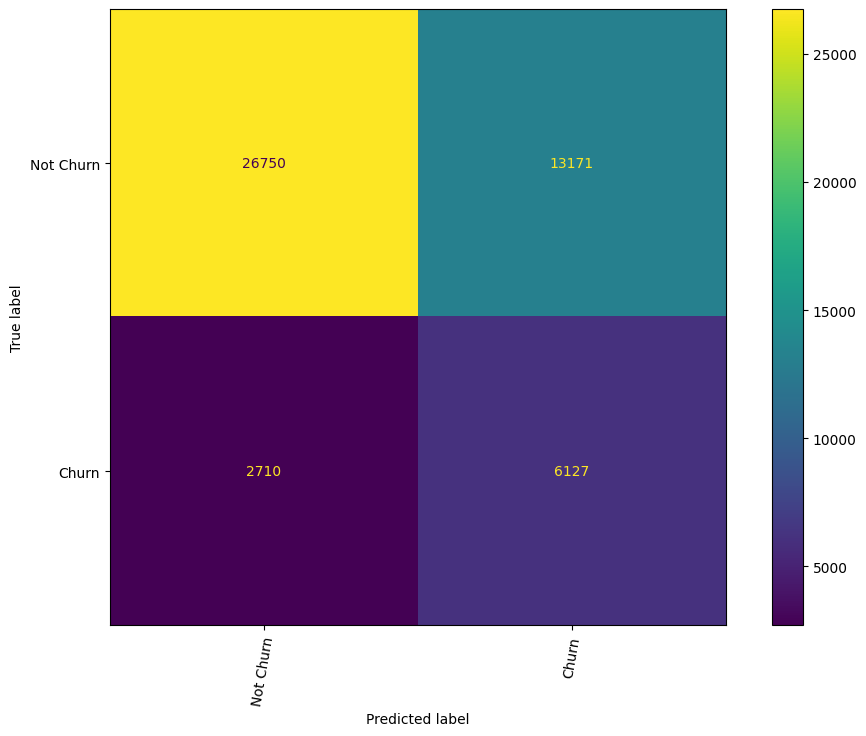

🏃 View run selective-eel-780 at: http://127.0.0.1:5050/#/experiments/1/runs/f067f7ca193941348d029ea5cef21b13
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1


In [44]:
lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression())
])

lr_search_space = {
    "clf__C": Real(1e-4, 1e3, prior="log-uniform"),
    "clf__max_iter": Integer(100, 1000), 
    "clf__tol": Real(1e-5, 1e-1, prior="log-uniform")
}

best_lrr, bayes_search_linear = optimize_and_log_model(
    lr,
    lr_search_space,
    "LogisticRegression",
    X_train_filtered, y_train,
    X_test_filtered, y_test,
    "Cristian",
    final_scaler_path,
    best_features_path,
    n_iter=25,
    cv=5,
    scoring="recall"
)

### Random forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

INFO:__main__:ROC AUC Score Train: 0.71
INFO:__main__:ROC AUC Score Test: 0.71
INFO:__main__:Precision Train: 0.7866430645603723
INFO:__main__:Precision Test: 0.7869374387470717
INFO:__main__:Recall Train: 0.6538412236128986
INFO:__main__:Recall Test: 0.654333647811641
INFO:__main__:Fscore Train: 0.6924054131890177
INFO:__main__:Fscore Test: 0.6928296279463392
INFO:__main__:Support Train: None
INFO:__main__:Support Test: None
INFO:__main__:Positive Precision Test: 0.29559940849523225
INFO:__main__:Positive Recall Test: 0.6559918524386104
INFO:__main__:Positive Fscore Test: 0.4075506186726659
INFO:__main__:Positive Support Test: None
INFO:__main__:Negative Precision Test: 0.8957011013140289
INFO:__main__:Negative Recall Test: 0.6539665840034067
INFO:__main__:Negative Fscore Test: 0.7559796142931604
INFO:__main__:Negative Support Test: None


Classification Report for Train:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76    159684
           1       0.30      0.66      0.41     35345

    accuracy                           0.65    195029
   macro avg       0.60      0.65      0.58    195029
weighted avg       0.79      0.65      0.69    195029

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76     39921
           1       0.30      0.66      0.41      8837

    accuracy                           0.65     48758
   macro avg       0.60      0.65      0.58     48758
weighted avg       0.79      0.65      0.69     48758



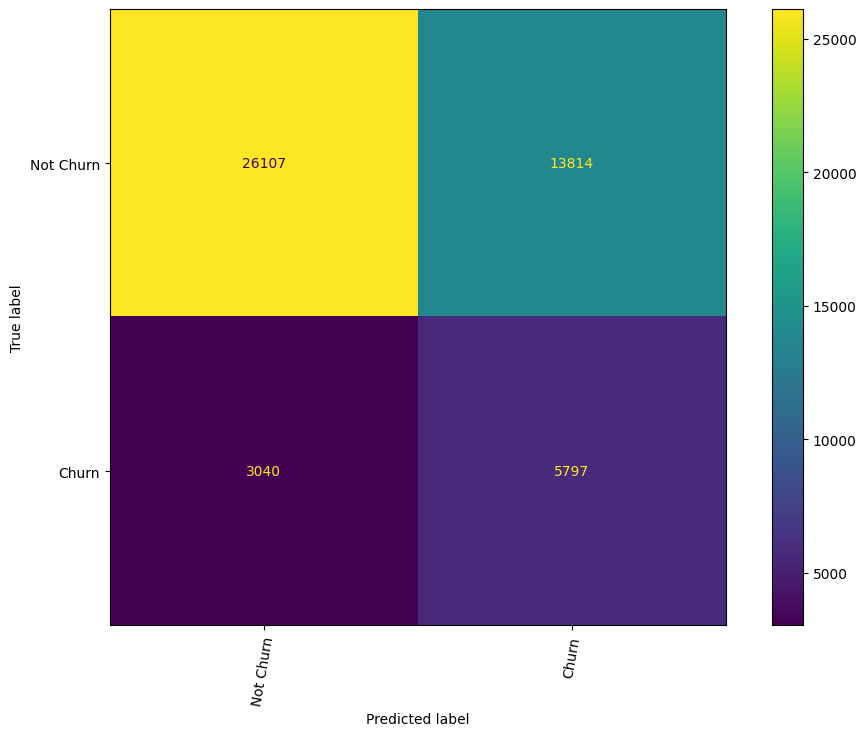

🏃 View run vaunted-fly-455 at: http://127.0.0.1:5050/#/experiments/1/runs/00031c6765d449e5bdc3607217b14e6f
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1


In [45]:
rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier())
])

rf_search_space = {
    "clf__n_estimators": Integer(10, 100),
    "clf__max_depth": Integer(3, 15),
    "clf__min_samples_split": Integer(2, 15),
    "clf__min_samples_leaf": Integer(1, 8),
    "clf__max_features": Real(0.3, 0.9),
    "clf__bootstrap": Categorical([True])
}

best_rf, bayes_search_rf = optimize_and_log_model(
    rf,
    rf_search_space,
    "RandomForestClassifier",
    X_train_filtered, y_train,
    X_test_filtered, y_test,
    developer="Cristian",
    scaler_path=final_scaler_path,
    features_path=best_features_path,
    n_iter=25,
    cv=5,
    scoring="recall"
)

### XGBoost

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

INFO:__main__:ROC AUC Score Train: 0.73
INFO:__main__:ROC AUC Score Test: 0.73
INFO:__main__:Precision Train: 0.7954353773985524
INFO:__main__:Precision Test: 0.7930242436564595
INFO:__main__:Recall Train: 0.6612555055914762
INFO:__main__:Recall Test: 0.6580253496862053
INFO:__main__:Fscore Train: 0.6991233655364143
INFO:__main__:Fscore Test: 0.6962842105745755
INFO:__main__:Support Train: None
INFO:__main__:Support Test: None
INFO:__main__:Positive Precision Test: 0.3022856854533528
INFO:__main__:Positive Recall Test: 0.6779450039606201
INFO:__main__:Positive Fscore Test: 0.4181323283082077
INFO:__main__:Positive Support Test: None
INFO:__main__:Negative Precision Test: 0.9016552057776702
INFO:__main__:Negative Recall Test: 0.6536158913854864
INFO:__main__:Negative Fscore Test: 0.7578565204763288
INFO:__main__:Negative Support Test: None


Classification Report for Train:
               precision    recall  f1-score   support

           0       0.90      0.66      0.76    159684
           1       0.31      0.68      0.42     35345

    accuracy                           0.66    195029
   macro avg       0.60      0.67      0.59    195029
weighted avg       0.80      0.66      0.70    195029

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76     39921
           1       0.30      0.68      0.42      8837

    accuracy                           0.66     48758
   macro avg       0.60      0.67      0.59     48758
weighted avg       0.79      0.66      0.70     48758



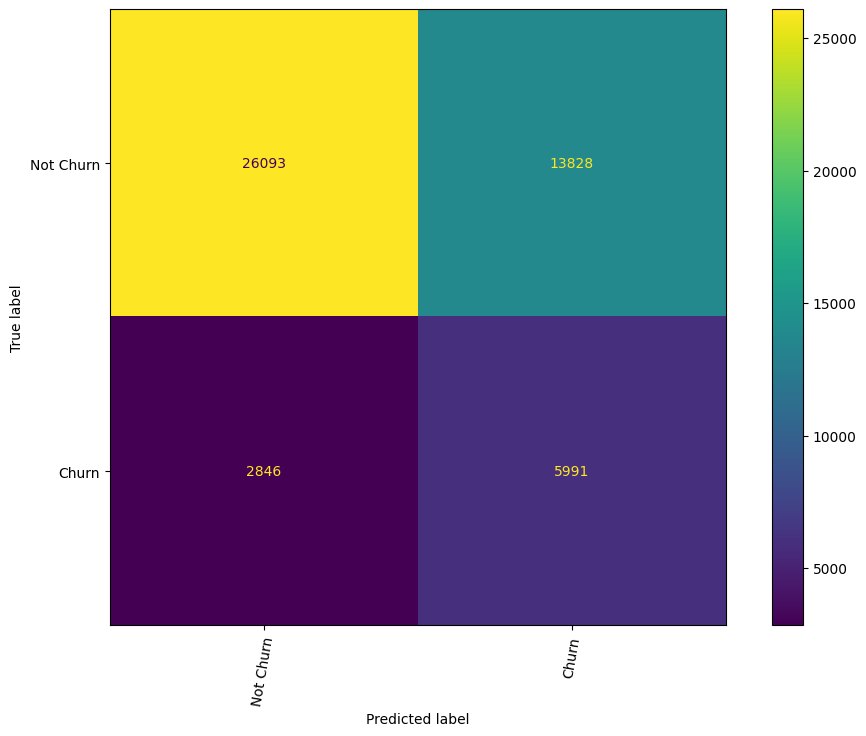

🏃 View run orderly-smelt-708 at: http://127.0.0.1:5050/#/experiments/1/runs/f2867447718e4a2b81d050119378e919
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1


In [46]:
xgb = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(random_state=42, verbosity=0, n_jobs=-1))
])

xgb_search_space = {
    "clf__n_estimators": Integer(20, 500),                    # Number of boosting rounds
    "clf__max_depth": Integer(3, 15),                          # Maximum depth of trees
    "clf__learning_rate": Real(0.01, 0.3, prior="log-uniform"),# Learning rate (eta)
    "clf__subsample": Real(0.5, 1.0),                          # Row sampling ratio
    "clf__colsample_bytree": Real(0.5, 1.0),                   # Feature sampling ratio per tree
    "clf__gamma": Real(0, 5.0),                                # Minimum loss reduction to split
    "clf__reg_alpha": Real(1e-5, 10.0, prior="log-uniform"),   # L1 regularization term
    "clf__reg_lambda": Real(1e-5, 10.0, prior="log-uniform")   # L2 regularization term
}

best_xgb, bayes_search_xgb = optimize_and_log_model(
    xgb,
    xgb_search_space,
    "XGBClassifier",
    X_train_filtered, y_train,
    X_test_filtered, y_test,
    developer="Cristian",
    scaler_path=final_scaler_path,
    features_path=best_features_path,
    n_iter=25,
    cv=5,
    scoring="recall"
)

### LGBMClassifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score:  0.6740132974961097
Best Hyperparameters:  OrderedDict({'clf__colsample_bytree': 0.9, 'clf__learning_ra

INFO:__main__:ROC AUC Score Train: 0.73
INFO:__main__:ROC AUC Score Test: 0.73
INFO:__main__:Precision Train: 0.793699889588908
INFO:__main__:Precision Test: 0.7930118154988776
INFO:__main__:Recall Train: 0.6580457265329771
INFO:__main__:Recall Test: 0.6582714631445096
INFO:__main__:Fscore Train: 0.6963447776960249
INFO:__main__:Fscore Test: 0.6964883263248937
INFO:__main__:Support Train: None
INFO:__main__:Support Test: None
INFO:__main__:Positive Precision Test: 0.3024089692439776
INFO:__main__:Positive Recall Test: 0.677605522236053
INFO:__main__:Positive Fscore Test: 0.41818562748795307
INFO:__main__:Positive Support Test: None
INFO:__main__:Negative Precision Test: 0.9016127361259799
INFO:__main__:Negative Recall Test: 0.6539916334761153
INFO:__main__:Negative Fscore Test: 0.7580940213130463
INFO:__main__:Negative Support Test: None


Classification Report for Train:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76    159684
           1       0.30      0.68      0.42     35345

    accuracy                           0.66    195029
   macro avg       0.60      0.67      0.59    195029
weighted avg       0.79      0.66      0.70    195029

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76     39921
           1       0.30      0.68      0.42      8837

    accuracy                           0.66     48758
   macro avg       0.60      0.67      0.59     48758
weighted avg       0.79      0.66      0.70     48758



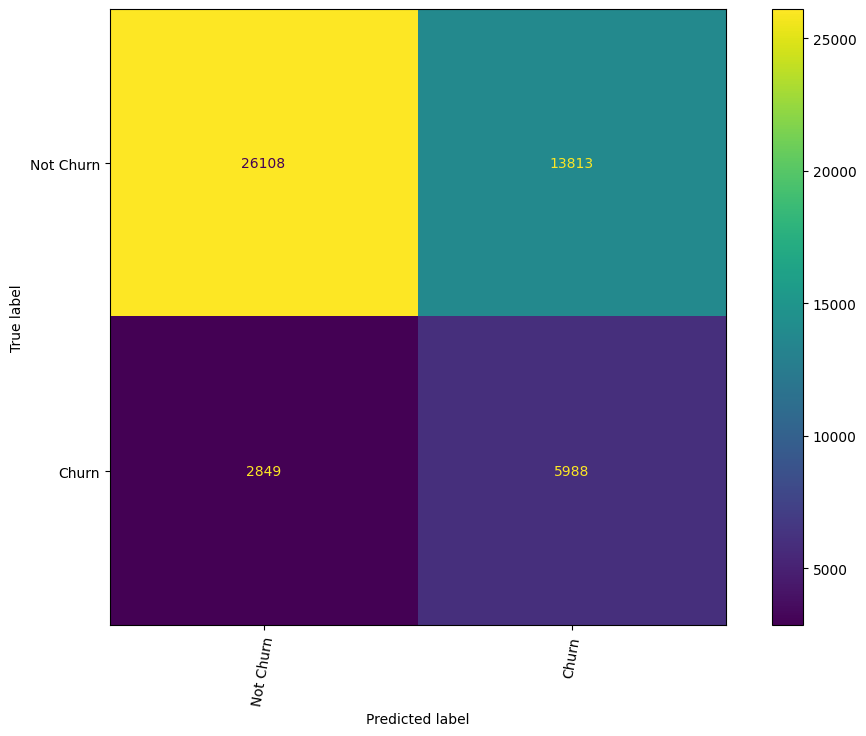

🏃 View run puzzled-gnu-821 at: http://127.0.0.1:5050/#/experiments/1/runs/4040476949c94e3da507336fa35dfd3d
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1


In [47]:
ligtbm = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1, boosting_type="gbdt"))
])

lgbm_search_space = {
    "clf__n_estimators": Integer(100, 500),
    "clf__max_depth": Integer(3, 10),
    "clf__learning_rate": Real(0.01, 0.2, prior="log-uniform"),
    "clf__num_leaves": Integer(15, 50),
    "clf__subsample": Real(0.6, 0.9),
    "clf__colsample_bytree": Real(0.6, 0.9),
    "clf__reg_alpha": Real(1e-3, 1.0, prior="log-uniform"),
    "clf__reg_lambda": Real(1e-3, 1.0, prior="log-uniform"),
    "clf__min_child_samples": Integer(10, 100),
}

best_svr, bayes_search_svr = optimize_and_log_model(
    ligtbm,
    lgbm_search_space,
    "LightGBM",
    X_train_filtered, y_train,
    X_test_filtered, y_test,
    developer="Cristian",
    scaler_path=final_scaler_path,
    features_path=best_features_path,
    n_iter=15,
    cv=5,
    scoring="recall"
)

# Register model in MLflow

In [48]:
client = MlflowClient(tracking_uri=tracking_uri)

In [49]:
experiments = client.search_experiments()
for experiment in experiments:
    print(experiment.name)
    print(experiment.artifact_location)
    print(experiment.tags)
    print("\n")

customer-churn-experiment
mlflow-artifacts:/1
{}


Default
mlflow-artifacts:/0
{}




In [50]:
experiment_id = -1

for experiment in experiments:
    if experiment.name == experiment_name:
        experiment_id = experiment.experiment_id
        break

print(experiment_id)

1


In [54]:
runs = client.search_runs(
    experiment_ids=[experiment_id],
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.positive_recall_test DESC"]
)

In [55]:
for run in runs:
    print(f"Run id: {run.info.run_id}, positive_recall_test: {run.data.metrics["positive_recall_test"]:.4f}, training_time: {run.data.metrics["training_time"]:.4f}")

Run id: f067f7ca193941348d029ea5cef21b13, positive_recall_test: 0.6933, training_time: 0.3313


In [56]:
run_id = runs[0].info.run_id
run_id

'f067f7ca193941348d029ea5cef21b13'

In [57]:
model_uri = f"runs:/{run_id}/model"
model_name = "customer-churn-model"
model_version = mlflow.register_model(
    model_uri,
    model_name
)

Successfully registered model 'customer-churn-model'.
2025/08/02 16:35:27 WARNING mlflow.tracking._model_registry.fluent: Run with id f067f7ca193941348d029ea5cef21b13 has no artifacts at artifact path 'model', registering model based on models:/m-e50ed972b02346b1944331995473725b instead
2025/08/02 16:35:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: customer-churn-model, version 1
Created version '1' of model 'customer-churn-model'.


In [58]:
client.set_registered_model_alias(
    name=model_name,
    version=model_version.version,
    alias="production"
)

In [59]:
client.get_model_version_by_alias(
    name=model_name,
    alias="production"
)

<ModelVersion: aliases=['production'], creation_timestamp=1754170527092, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1754170527092, metrics=None, model_id=None, name='customer-churn-model', params=None, run_id='f067f7ca193941348d029ea5cef21b13', run_link='', source='models:/m-e50ed972b02346b1944331995473725b', status='READY', status_message=None, tags={}, user_id='', version='1'>